In [1]:
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from brainflow.data_filter import DataFilter, WindowOperations, DetrendOperations, NoiseTypes, WaveletTypes

import scipy.signal as ss

import argparse
import time

from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels
from brainflow.data_filter import DataFilter
from brainflow.ml_model import MLModel, BrainFlowMetrics, BrainFlowClassifiers, BrainFlowModelParams

### useful links
#### [simple brainflow examples](https://brainflow.readthedocs.io/en/stable/Examples.html)
#### [brainflow github](https://github.com/brainflow-dev/brainflow) look under python_package/examples also
#### [MNE](https://mne.tools/stable/index.html) could send data to this and use to process [example here](https://github.com/brainflow-dev/brainflow/blob/master/python_package/examples/tests/brainflow_to_mne.py)

In [2]:
BoardShim.enable_dev_board_logger()

# use synthetic board for demo
params = BrainFlowInputParams()
board_id = BoardIds.SYNTHETIC_BOARD.value
board_descr = BoardShim.get_board_descr(board_id)
sampling_rate = int(board_descr['sampling_rate'])
board = BoardShim(board_id, params)
board.prepare_session()
board.start_stream()

BoardShim.log_message(LogLevels.LEVEL_INFO.value, 'start sleeping in the main thread')
time.sleep(10)

data = board.get_board_data()
board.stop_stream()
board.release_session()

[2025-02-21 12:52:05.715] [board_logger] [info] incoming json: {
    "file": "",
    "file_anc": "",
    "file_aux": "",
    "ip_address": "",
    "ip_address_anc": "",
    "ip_address_aux": "",
    "ip_port": 0,
    "ip_port_anc": 0,
    "ip_port_aux": 0,
    "ip_protocol": 0,
    "mac_address": "",
    "master_board": -100,
    "other_info": "",
    "serial_number": "",
    "serial_port": "",
    "timeout": 0
}
[2025-02-21 12:52:05.715] [board_logger] [trace] Board object created -1
[2025-02-21 12:52:05.716] [board_logger] [info] start sleeping in the main thread


In [3]:
board_descr

{'accel_channels': [17, 18, 19],
 'battery_channel': 29,
 'ecg_channels': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'eda_channels': [23],
 'eeg_channels': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'eeg_names': 'Fz,C3,Cz,C4,Pz,PO7,Oz,PO8,F5,F7,F3,F1,F2,F4,F6,F8',
 'emg_channels': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'eog_channels': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'gyro_channels': [20, 21, 22],
 'marker_channel': 31,
 'name': 'Synthetic',
 'num_rows': 32,
 'package_num_channel': 0,
 'ppg_channels': [24, 25],
 'resistance_channels': [27, 28],
 'sampling_rate': 250,
 'temperature_channels': [26],
 'timestamp_channel': 30}

In [4]:
# can load data into df
df = pd.DataFrame(np.transpose(data))
df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,11.752635,28.430164,51.295103,72.100737,93.551646,130.019849,299.880615,394.657776,405.254517,...,0.844278,1.032624,463.140042,262251.767022,36.590569,944.601129,976.815219,91.283978,1.740164e+09,0.0
1,1.0,13.602113,36.228928,60.248265,101.225210,116.405251,146.642679,344.073492,366.087715,278.433538,...,0.883176,1.058800,489.126183,259441.978523,36.597839,976.835361,924.279069,92.587866,1.740164e+09,0.0
2,2.0,15.049657,38.778322,71.516939,102.227871,118.601234,124.652044,92.401421,47.007799,4.287036,...,0.850893,0.937054,458.326501,274470.365943,36.602605,911.891455,1068.910979,80.677059,1.740164e+09,0.0
3,3.0,16.637910,43.928963,78.116826,81.849226,79.603075,47.420996,8.139212,-61.137631,17.716936,...,0.808337,1.012615,463.925859,252945.472437,36.606479,946.055845,973.345414,94.411151,1.740164e+09,0.0
4,4.0,18.208797,48.067069,74.416671,64.023471,34.631226,2.603399,-34.602438,-40.226354,62.868853,...,0.819774,0.971425,543.610857,251730.187446,36.609547,1009.838451,942.528825,97.872424,1.740164e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,193.0,6.616481,8.224146,1.040409,-3.572191,-2.278238,-8.136045,-21.788289,-47.422143,5.117120,...,0.850470,1.063544,460.333348,258886.497430,36.602650,1055.804402,1023.137179,95.428034,1.740164e+09,0.0
2498,194.0,8.139437,13.917021,19.363279,22.065606,26.436203,27.125537,25.975804,-5.487817,-21.869858,...,0.801622,1.045261,458.818433,233607.359873,36.598298,1055.813433,1005.296785,86.626663,1.740164e+09,0.0
2499,195.0,10.000000,21.370810,34.629680,47.647933,66.461952,78.387475,90.229394,122.901943,150.848303,...,0.854964,0.995853,497.949470,257156.628738,36.599553,1083.724599,925.743754,98.545620,1.740164e+09,0.0
2500,196.0,11.810393,28.449405,48.769770,76.990812,105.997072,139.700554,184.186708,203.376691,197.514833,...,0.802964,0.900441,513.657731,255351.082687,36.604562,1092.268690,936.187094,87.821121,1.740164e+09,0.0


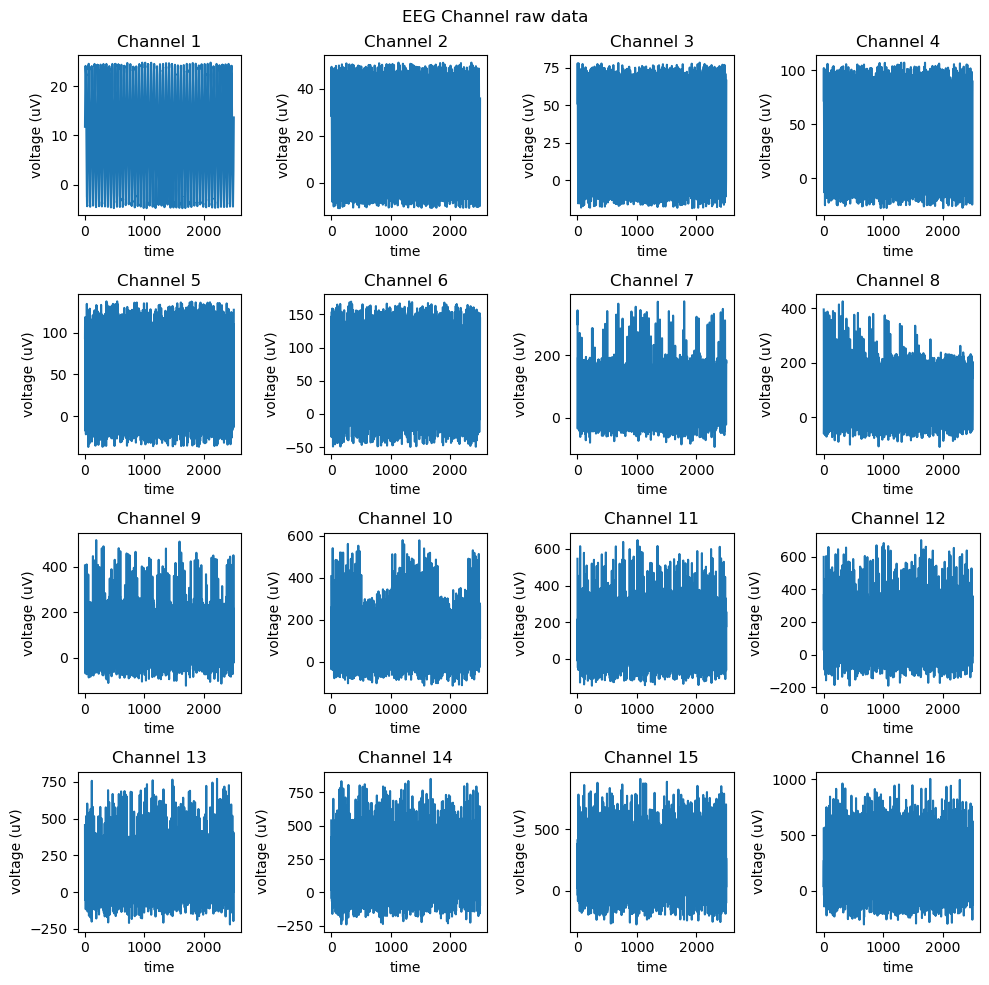

In [5]:
eeg_channels = board_descr['eeg_channels']
num_channels = len(eeg_channels)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.ravel()
fig.suptitle("EEG Channel raw data")

for i, channel in enumerate(eeg_channels):
    axes[i].plot(data[channel])
    axes[i].set_title(f"Channel {channel}")
    axes[i].set_xlabel("time")
    axes[i].set_ylabel("voltage (uV)") #probs what our voltage unit will be 

plt.tight_layout()
plt.show()

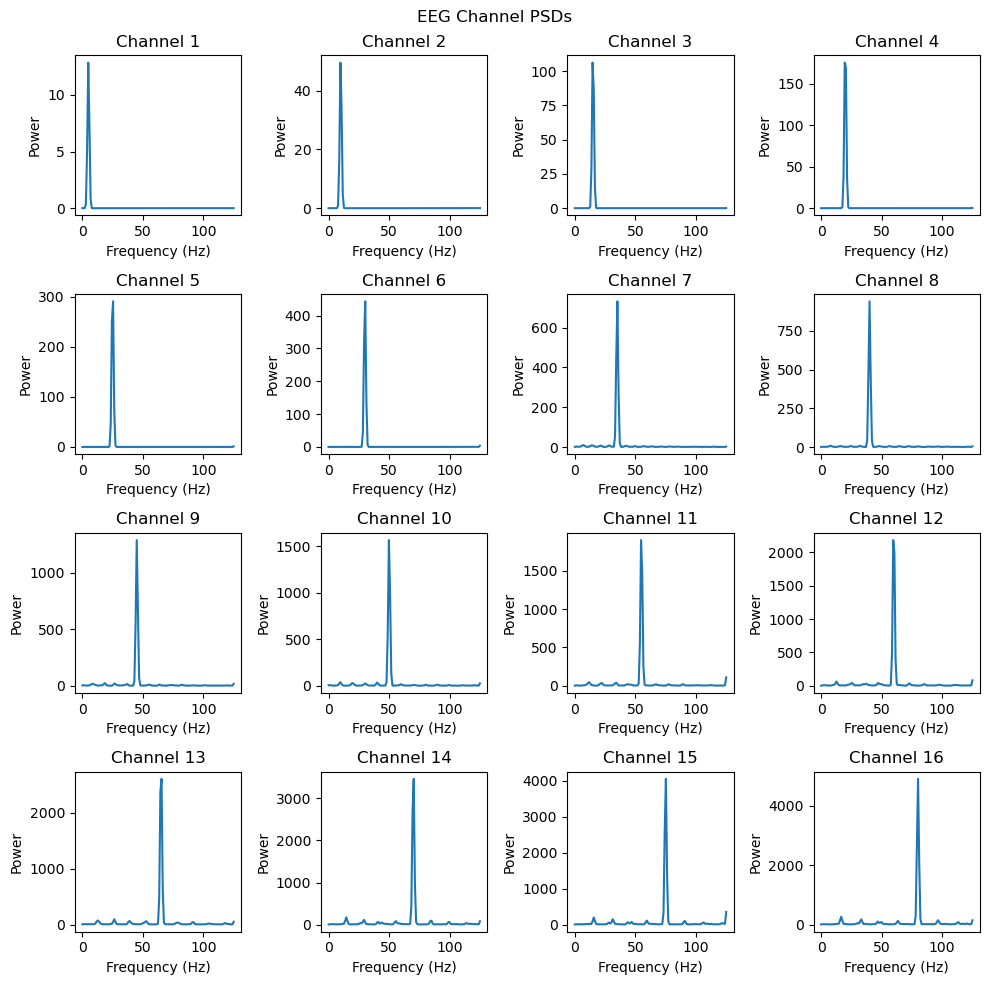

In [6]:
nfft = DataFilter.get_nearest_power_of_two(sampling_rate)

fig, axes = plt.subplots(4, 4, figsize=(10, 10)) 
axes = axes.ravel()
fig.suptitle("EEG Channel PSDs")

for i, channel in enumerate(eeg_channels):
    DataFilter.detrend(data[channel], DetrendOperations.LINEAR.value) # i think this overwrites the data[channel] by default kinda like pandas inplace 
    power, hz = DataFilter.get_psd_welch(data[channel], nfft, nfft // 2, sampling_rate, WindowOperations.BLACKMAN_HARRIS.value)
    
    axes[i].plot(hz, power)
    axes[i].set_title(f"Channel {channel}")
    axes[i].set_xlabel("Frequency (Hz)")
    axes[i].set_ylabel("Power")

plt.tight_layout()
plt.show()


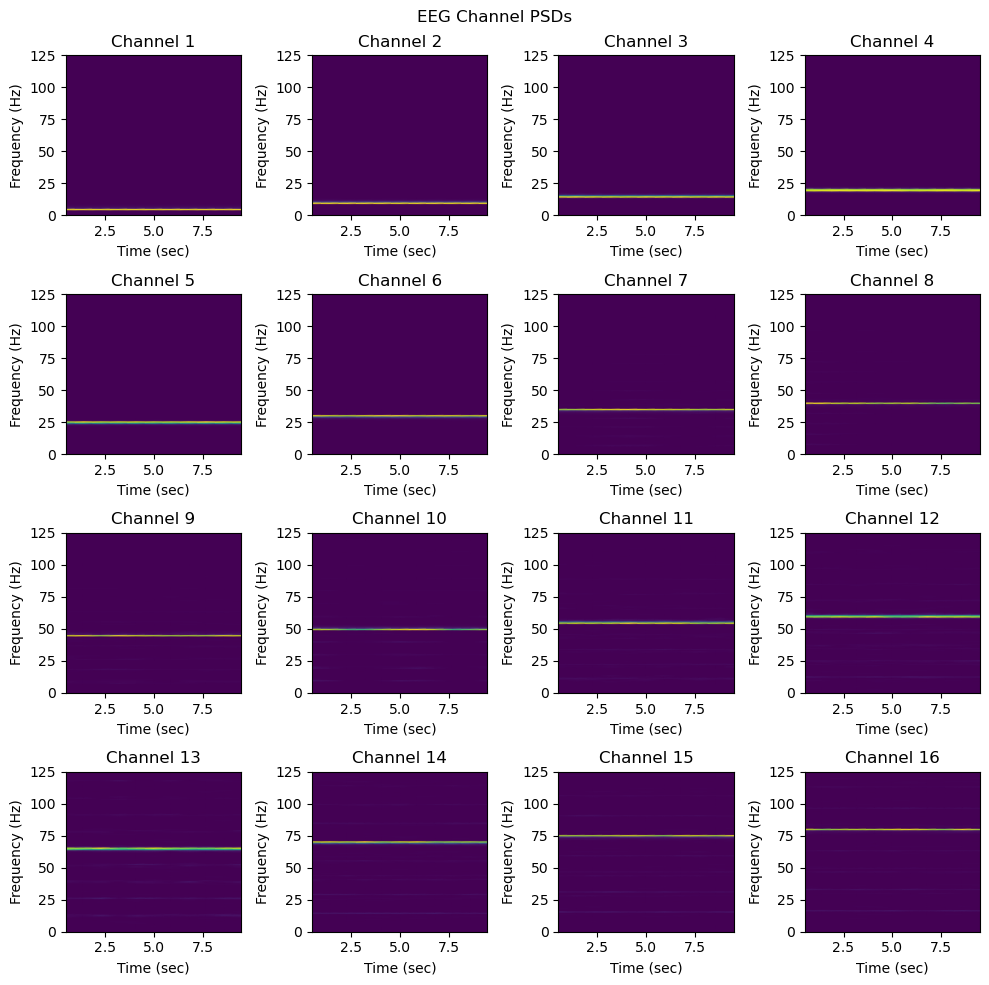

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10)) 
axes = axes.ravel()
fig.suptitle("EEG Channel PSDs")

for i, channel in enumerate(eeg_channels):
    
    # could replace with Pywavelet
    f, t, Sxx = ss.spectrogram(data[channel],sampling_rate)

    axes[i].pcolormesh(t, f, Sxx, shading='gouraud')
    axes[i].set_title(f"Channel {channel}")
    axes[i].set_ylabel('Frequency (Hz)')
    axes[i].set_xlabel('Time (sec)')
    

plt.tight_layout()
plt.show()


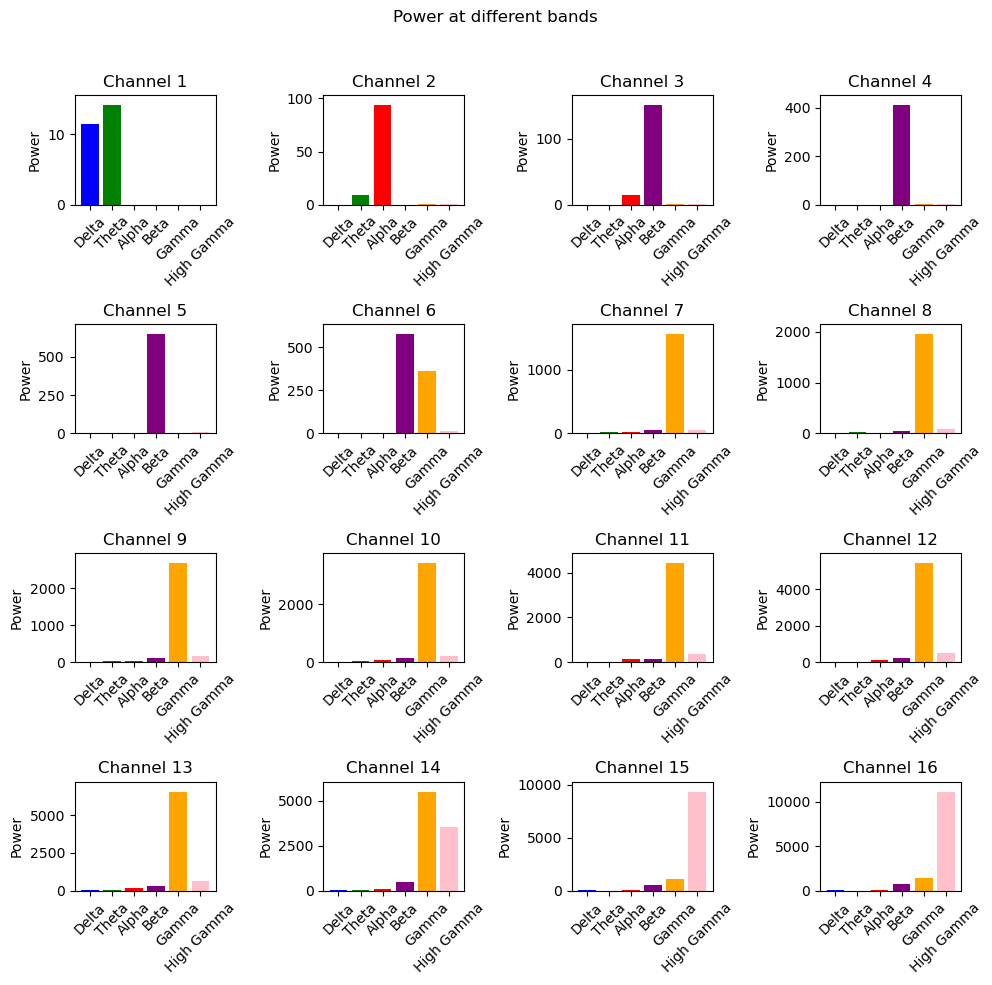

In [8]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.ravel()
fig.suptitle("Power at different bands")

for i, channel in enumerate(eeg_channels):
    psd = DataFilter.get_psd_welch(data[channel], nfft, nfft // 2, sampling_rate, WindowOperations.BLACKMAN_HARRIS.value)

    # Calculate band powers for different frequency bands
    band_power_delta = DataFilter.get_band_power(psd, 0.01, 4)
    band_power_theta = DataFilter.get_band_power(psd, 4, 8)
    band_power_alpha = DataFilter.get_band_power(psd, 8.0, 13.0)
    band_power_beta = DataFilter.get_band_power(psd, 14.0, 30.0)
    band_power_gamma = DataFilter.get_band_power(psd, 30, 70.0)
    band_power_high_gamma = DataFilter.get_band_power(psd, 70, 200)

    # Create a bar plot for the power at different bands
    band_powers = [band_power_delta, band_power_theta, band_power_alpha, band_power_beta, band_power_gamma, band_power_high_gamma]
    bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma']
    
    # Plot bars
    axes[i].bar(bands, band_powers, color=['blue', 'green', 'red', 'purple', 'orange', 'pink'])
    axes[i].set_title(channel)
    axes[i].set_title(f"Channel {channel}")
    axes[i].set_ylabel('Power')
    axes[i].set_ylim(0, max(band_powers) * 1.1)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust spacing to avoid overlap with the suptitle
plt.show()


### could use these metrics to find out if they are focused or not. 

In [9]:
# calculate avg and stddev of BandPowers 
# across all channels, bands are 1-4,4-8,8-13,13-30,30-50
bands = DataFilter.get_avg_band_powers(data, eeg_channels, sampling_rate, True)

feature_vector = bands[0]

mindfulness_params = BrainFlowModelParams(BrainFlowMetrics.MINDFULNESS.value,
                                            BrainFlowClassifiers.DEFAULT_CLASSIFIER.value)

# mindfulness is the focus metric 
mindfulness = MLModel(mindfulness_params)
mindfulness.prepare()
print('Mindfulness: %s' % str(mindfulness.predict(feature_vector)))
mindfulness.release()

# restfulness is the relaxation metric 
restfulness_params = BrainFlowModelParams(BrainFlowMetrics.RESTFULNESS.value,
                                            BrainFlowClassifiers.DEFAULT_CLASSIFIER.value)
restfulness = MLModel(restfulness_params)
restfulness.prepare()
print('Restfulness: %s' % str(restfulness.predict(feature_vector)))
restfulness.release()

Mindfulness: [1.]
Restfulness: [1.65293779e-10]


### this has all been processing saved data. The project will actually be decoding in real time. So we have a few things to do 
#### 1) make sure we can read in data from our openBCI device 
* ##### start with trying to bring in recorded data and then try real time.
* ##### is our recording device good enough to show see if someone is focused.
#### 3) see if we can find any info about the focus and relaxtion metric. Is this a good metric for us to use?
#### 4) is the processing in brainflow good enough?
#### 5) Come up with ideas for what to show the user when they are focused